<a href="https://colab.research.google.com/github/igordantasgf/analise_dados_microambientais/blob/main/compara%C3%A7%C3%A3o_modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dados do modelo WRF

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import datetime
from sys import exit

labmim = pd.read_csv('/content/drive/MyDrive/Bolsa - Edson/estudos/código_paper_bruno/labmim_completo_2016_2022.dat',sep=';')
labmim.index = pd.to_datetime(labmim['year month day hour'.split()])

sw_dir = []
for dw, dif in zip(labmim['Sw_dw'],labmim['Sw_dif']):
    if not np.isnan(dw) and not np.isnan(dif) and dw-dif > 0:
        sw_dir.append(dw-dif)
    else:
        sw_dir.append(np.nan)

# filtro sw_dif errado
labmim[labmim['Sw_dif']>600] = np.nan

def plotar(banco):
  #panorama completo
  #banco['oc_topo'].plot()
  #banco['Sw_dw'].plot()
  #banco['Sw_dif'].plot()

  #plt.ylabel('Radiação (W/m²)')
  #plt.legend()
  #plt.savefig('rad-panorama.png',bbox_inches='tight')
  plt.show()
  plt.close()
  print("Valores NaN:")
  print('Sw_dw',banco["Sw_dw"].isna().sum())
  print('Sw_dif',banco["Sw_dif"].isna().sum())
  print('oc_topo',banco["oc_topo"].isna().sum())

This code below creates a function called zero_or_nan_values that takes in two parameters: a DataFrame and a column name. The function creates a new column called 'date' that combines the 'year', 'month', and 'day' columns into a single date format. It then groups the Data Frame by the 'date' column, iterates through each group (i.e. each day), and counts the number of non-zero and non-NaN values in the column specified in the parameter. If the count is less than 8, it sets all values in the column for that day to NaN. The function returns the modified DataFrame.

In [ ]:
def zero_or_nan_values(df, column):
    # Create a new column 'date' that combines the year, month, and day columns
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

    # Group the Data Frame by the 'date' column
    grouped = df.groupby('date')

    # Iterate through each group (i.e. each day)
    for name, group in grouped:
        # Count the number of non-zero and non-NaN values in the 'Sw_dw' column
        count = group[column].count()
        # If the count is less than 8
        if count < 8:
            # Set all values in the 'Sw_dw' column for that day to NaN
            df.loc[df['date'] == name, column] = pd.np.nan
    return df

zero_or_nan_values(labmim, 'oc_topo')
zero_or_nan_values(labmim, 'Sw_dw')
zero_or_nan_values(labmim, 'Sw_dif')

## As comparações entre uma base de dados obtida em laboratório e uma base de dados modelada podem incluir:

- Comparação de valores médios: Verificar se os valores médios obtidos a partir de dados experimentais e dados modelados são similares.

- Comparação de distribuições: Verificar se a distribuição de valores obtidos a partir de dados experimentais e dados modelados é semelhante.

- Comparação de tendências: Verificar se as tendências ao longo do tempo nos dados experimentais e modelados são similares.

- Comparação de desvios padrão: Verificar se os desvios padrão dos dados experimentais e modelados são semelhantes.

- Comparação de correlação: Verificar se a correlação entre as variáveis ​​dos dados experimentais e modelados é similar.

- Comparação de outliers: Verificar se há outliers semelhantes nos dados experimentais e modelados.

- Verificação de hipóteses: Verificar se as hipóteses que foram feitas sobre os dados experimentais e modelados são verdadeiras.

Essas comparações podem ser realizadas usando diferentes métodos estatísticos, como análise de variância (ANOVA), testes t, regressão linear, entre outros. O objetivo final é avaliar a precisão e a confiabilidade do modelo e identificar possíveis ajustes necessários.

* Importando dados e colunas

In [ ]:
# Dados do modelo WRF
series = pd.read_csv('/content/drive/MyDrive/Bolsa - Edson/estudos/código_paper_bruno/series_operacional', sep=',')
series.index = pd.to_datetime(series['year month day hour'.split()])

#series.index
#series.columns

#labmim.index
#labmim.columns

inicio = max(series.index[0], labmim.index[0])
fim = min(series.index[-1], labmim.index[-1])

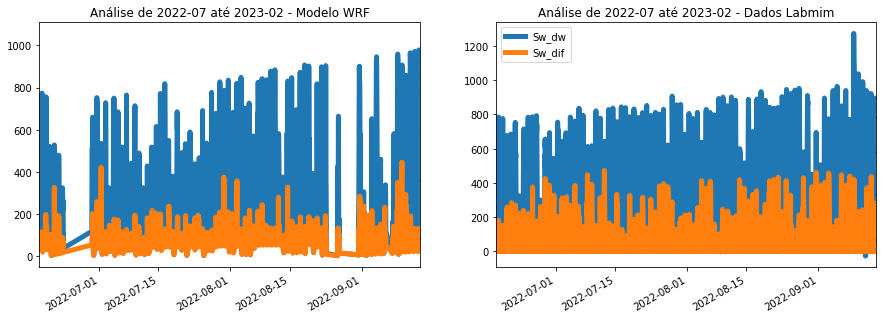

In [ ]:
# Dados obtidos no labmim
labmim = pd.read_csv('/content/drive/MyDrive/Bolsa - Edson/estudos/código_paper_bruno/labmim_completo_2016_2022.dat',sep=';')
labmim.index = pd.to_datetime(labmim['year month day hour'.split()])

series = series.dropna(subset=['Swdf','Swdw'])
series['Swdf'].replace(0, float('NaN'), inplace=True)
series['Swdw'].replace(0, float('NaN'), inplace=True)
labmim = labmim.dropna(subset=['Sw_dif','Sw_dw'])
labmim['Sw_dif'].replace(0, float('NaN'), inplace=True)
labmim['Sw_dw'].replace(0, float('NaN'), inplace=True)

#plotting
fig, ax = plt.subplots(1,2,figsize=(15, 5))

ax[0].set_title("Análise de 2022-07 até 2023-02 - Modelo WRF")
ax[0].plot_date(series.index, series['Swdw'], ls='-', lw=5, markersize=1, label='Sw_dw')
ax[0].plot_date(series.index, series['Swdf'], ls='-', lw=5, markersize=1, label='Sw_dif')
plt.legend()
fig.autofmt_xdate()
ax[0].set_xlim([inicio,fim])

ax[1].set_title("Análise de 2022-07 até 2023-02 - Dados Labmim")
ax[1].plot_date(labmim.index, labmim['Sw_dw'], ls='-', lw=5, markersize=1, label='Sw_dw')
ax[1].plot_date(labmim.index, labmim['Sw_dif'], ls='-', lw=5, markersize=1, label='Sw_dif')
plt.legend()
fig.autofmt_xdate()
ax[1].set_xlim([inicio,fim])

plt.show()

**Observação:**
- É necessário filtrar dados com erro, como o dado acima de 1200 no gráfico a direita



### Análise de médias mensais
-  Corrigir:\
  Descartar dias com chuva \
  Descartar dias com menos de 8 dados válidos

<ipython-input-104-89118d266fa2>:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  ss = series[str(inicio):str(fim)]


Text(0.5, 1.0, 'Boxplot mensal')

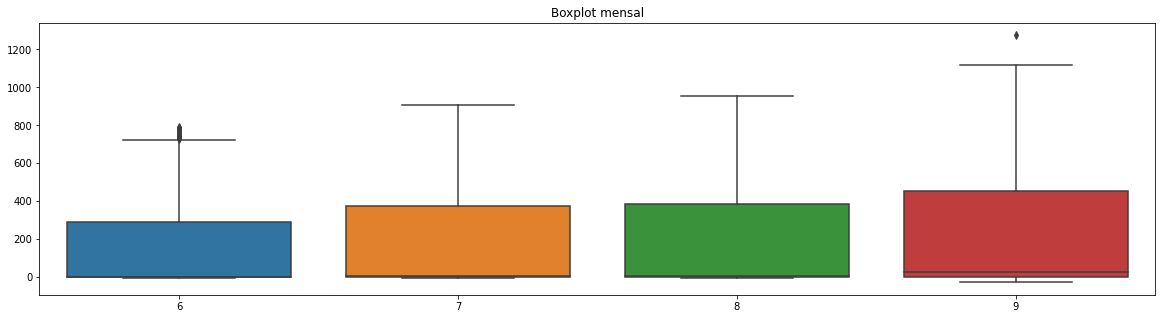

In [ ]:
lab = labmim[str(inicio):str(fim)]
ss = series[str(inicio):str(fim)]

dados = lab
parametro = "Sw_dw"

grouped = dados.groupby('month')
grouped = pd.DataFrame(grouped)
lista = []
#grouped[1][0]["Sw_dw"]
for i in grouped[1]:
  lista.append(i[parametro])

fig, ax1 = plt.subplots(figsize=(20,5))
ax1 = sns.boxplot(data = lista, orient='v')
ax1.set_xticklabels(grouped[0])
ax1.set_title("Boxplot mensal")